In [1]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate


to_test = False

In [2]:
computed_table_pre = dict()
computed_table_pre['g'] = dict() #global
computed_table_pre['b'] = dict() #borderc_control
computed_table_pre['s'] = dict() #single
computed_table_pre['m'] = dict() #multi-control
computed_table_pre['d'] = dict() #dif-branceh
computed_table_pre['r'] = dict() #merge 
computed_table_pre['n'] = dict() #non-reduce
def simulate(cir,ini=False,n=0):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
    # n = get_real_qubit_num(cir)
    if n!=0:
        add_inputs(tn,[0]*n,n)
    
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for k1 in range(n):
            if not 'x'+str(k1) in var:
                var.append('x'+str(k1))
            for k in range(5*len(all_indexs)):
                s ='x'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)               
            if not 'y'+str(k1) in var:
                var.append('y'+str(k1))
        var.reverse()
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)
        # computed_table_pre = dict()
        # computed_table_pre['g'] = dict()
        # computed_table_pre['b'] = dict()
        # computed_table_pre['s'] = dict()
        # computed_table_pre['m'] = dict()
        # computed_table_pre['d'] = dict()
        # computed_table_pre['r'] = dict()
        # computed_table_pre['n'] = dict()
#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    # temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    temp_tdd = Slicing2(tdd,tdd.node.key,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

def get_gate_data(cir):
    data = {}
    for d in cir.data:
        a = len(d.qubits)
        if a in data:
            data[a]+=1
        else:
            data[a]=1
    return data

def get_gate_data2(cir):
    data = 0
    for d in cir.data:
        data += len(d.qubits)
    return data

In [3]:
def get_dependency_cycle(node,G=None):

    if isinstance(node, TDD):
        node = node.node

    if G==None:
        G = nx.Graph()

    if node.key ==-1:
        return G
        
    # if not node in computed_table_pre['g']:
    #     computed_table_pre['g'][node]=1
    # else:
    #     computed_table_pre['g'][node]+=1   
        
    G = get_dependency_cycle(node.successor[0])

    the_map1 = node.out_maps[1]
    
    if node.out_weight[1]==0 or node.successor[0]!=node.successor[1] or the_map1.level>-1:# 
        G.add_node(node.key,label=node.key,map = {})
    else:
        a = node.out_weight[1]
        # print(a)
        M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
        G.add_node(node.key,label=node.key,map = {'u2' : M})
        M_conj=M.T.conjugate()
        err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
        if err>1e-8:
            print('Not Unitary')
            print(M,err,M@M_conj)
    
    while the_map1.level>-1:
        if (node.key, the_map1.level) in G.edges:
            G.edges[(node.key,the_map1.level)]['map']['x'] = the_map1.x
            G.edges[(node.key,the_map1.level)]['map']['rotate'] = the_map1.rotate
        else:
            G.add_edge(node.key, the_map1.level,map={'x': the_map1.x, 'rotate': the_map1.rotate})
        the_map1=the_map1.father
    
    # if node.key%2==1:
    #     U=np.array([[1,1],[node.successor[0].out_weight[1],node.successor[1].out_weight[1]]],dtype=complex)
    #     if node.out_maps[1].level==node.key-1:
    #         if node.out_maps[1].rotate>0:
    #             U[1][1]=U[1][1]*np.exp(1j*np.pi/4*(node.out_maps[1].rotate))
    #         if node.out_maps[1].x==1:
    #             U[0][1],U[1][1]=U[1][1],U[0][1]
    #     G.add_edge(node.key, node.key-1,map={'u':U})
        
    if node.successor[0]!=node.successor[1]:
        # print(node.key)
        node0 = node.successor[0]
        node1 = node.successor[1]
        if TDD(node0).node_number() == node.key+1 and TDD(node1).node_number() == node.key+1:
            for k in range(node.key-1,-1,-1):
                if node0.out_maps[1]!=node1.out_maps[1]:
                    the_map2,the_phase = node0.out_maps[1]/node1.out_maps[1]
                    if (node.key, k) in G.edges:
                        G.edges[(node.key,k)]['map']['x2'] = the_map2
                    else:
                        G.add_edge(node.key, k,map={'x2': the_map2})
                    # while the_map2.level>-1:
                    #     G.add_edge(node.key,the_map2.level,map={})
                    #     G.add_edge(k,the_map2.level,map={})
                    #     the_map2=the_map2.father

                a=node0.out_weight[1]
                b=node1.out_weight[1]
                # print(a,b)
                if a!=b:
                    # theta = float(np.arctan((a-b)/(1+a*b)))
                    # U = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
                    # print(theta)
                    # print(a,b)
                    M = 1/np.sqrt(1+abs(b)**2)*1/np.sqrt(1+abs(a)**2)*np.array([[1,-np.conj(a)],[a,1]])@np.array([[1,np.conj(b)],[-b,1]])
                    err = M@np.array([1,b])-np.array([np.sqrt(1+abs(b)**2)/np.sqrt(1+abs(a)**2),a*np.sqrt(1+abs(b)**2)/np.sqrt(1+abs(a)**2)])
                    if abs(err[0])>1e-8 or abs(err[1])>1e-8:
                        print('Not Zero')
                    M_conj=M.T.conjugate()
                    err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
                    if err>1e-8:
                        print('Not Unitary2')
                        print(M,err,M@M_conj)                        
                    if (node.key, k) in G.edges:
                            G.edges[(node.key,k)]['map']['u2'] = M
                    else:
                            G.add_edge(node.key, k,map={'u2':M})
                    # print(node.key,k,theta)
                    
                node0 = node0.successor[0]
                node1 = node1.successor[0]
                if node0==node1:
                    break

    return G

In [4]:
def eliminate_global_map(tdd):
    if to_test:
        print('global')   
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        # print(idx,q)
        
        if the_map.rotate>0:
            cir_end.p(np.pi/4*(8-the_map.rotate),q) 
            
        if the_map.x==1:
            cir_end.x(q)

        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end

In [5]:
def get_border_control_pos(tdd,G):
    res = []
    for idx in range(tdd.node.key,-1,-1):
        A = list(G.neighbors(idx))
        calculated = []
        for idx2 in A:
            if isinstance(idx2,str):
                a=int(idx2.split('_')[0])
            else:
                a = idx2
            if a in calculated:
                continue
            else:
                calculated.append(a)
            if a<idx:
                if 'x' in G.edges[idx,idx2]['map']:
                    res.append([idx,idx2])
    # print(res)
    return res
            
def eliminate_border_control(tdd,G=None):
    if to_test:
        print('border')   
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    # node = tdd.node
    # if not node in computed_table_pre['b']:
    #     computed_table_pre['b'][node]=1
    # else:
    #     computed_table_pre['b'][node]+=1   
    
    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_border_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for [idx1,idx2] in res:
        q_c = int(tdd.key_2_index[idx1][1:])
        if isinstance(idx2,str):
            q = int(tdd.key_2_index[int(idx2.split('_')[0])][1:])
        else:
            q = int(tdd.key_2_index[idx2][1:])
        # print(q_c,q)
        temp_map = G.edges[idx1,idx2]['map']
        # if not 'x' in temp_map:
        #     continue
        if 0 and idx1%2==1:
            if temp_map['rotate']>0:
                cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            if temp_map['x']==1:
                cir_head.cx(q_c,q)
        else:
            if temp_map['rotate']>0:
                cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            if temp_map['x']==1:
                cir_end.cx(q_c,q)


    tdd_new = update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t 
    return tdd_new,cir_head,cir_end

In [6]:
def get_sigle_qubit_gates(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if not idx in G:
            continue

        if 'u2' in G.nodes[idx]['map']:
            A = list(G.neighbors(idx))
            if len(A)==0:
                res[idx] = G.nodes[idx]['map']['u2']
    # print(res)
    return res

def eliminate_sigle_qubit_gates(tdd,G=None):
    if to_test:
        print('Single')
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    # node=tdd.node
    # if not node in computed_table_pre['s']:
    #     computed_table_pre['s'][node]=1
    # else:
    #     computed_table_pre['s'][node]+=1   
    if G==None:
        G = get_dependency_cycle(tdd)

    res = get_sigle_qubit_gates(tdd,G)
    
    if not res:
        return tdd.self_copy(),cir_head,cir_end
    # print('a',res)
    for idx in res:
        q = int(tdd.key_2_index[idx][1:])
        M = res[idx]
        # print(M,q)
        cir_end.unitary(M,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)
    if tdd_new==tdd:
        return tdd,cir_head,cir_end
        
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t

    G = get_dependency_cycle(tdd_new)
    res1 = get_border_control_pos(tdd_new,G)
    if res1:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t

    if tdd_new==tdd:
        return tdd,cir_head,cir_end
    
    G = get_dependency_cycle(tdd_new)
    res2 = get_sigle_qubit_gates(tdd_new,G)
    # print('b',res)
    if res2:
            tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t        
    return tdd_new,cir_head,cir_end

In [7]:
def get_multi_control_pos(tdd,G=None):
    if G==None:
        G=get_dependency_cycle(tdd)
    
    res = {}
    for idx in range(tdd.node.key,-1,-1):
            A = list(G.neighbors(idx))
            C=[x for x in A if isinstance(x,int) and x<idx]
            C=[x for x in C if 'x2' in G.edges[idx,x]['map']]
            if len(C)>0:
                res[idx] = C
    # print(res)
    return res

def merge_multi_control(tdd):
    if to_test:
        print('mul_control')
    # node=tdd.node
    # if not node in computed_table_pre['m']:
    #     computed_table_pre['m'][node]=1
    # else:
    #     computed_table_pre['m'][node]+=1       
    G=get_dependency_cycle(tdd)
    pos = get_multi_control_pos(tdd,G)

    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)    
    if len(pos)==0:
        return tdd,cir_head,cir_end

    # print(pos)
    for idx0 in pos:
        for idx1 in pos[idx0]:
            q0 = int(tdd.key_2_index[idx0][1:])
            q1 = int(tdd.key_2_index[idx1][1:])
            the_map = G.edges[idx0,idx1]['map']['x2']
            while the_map.level>-1:
                idx = the_map.level
                q = int(tdd.key_2_index[idx][1:])
                if not q0>q1>q:
                    the_map=the_map.father
                    continue 
                if the_map.rotate>0:
                    cir_end.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
                if the_map.x==1:
                    cir_end.ccx(q0,q1,q)
                the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)

    if tdd_new==tdd:
        return tdd,cir_head,cir_end
    
    tdd_new,cir_head2,cir_end2=eliminate_global_map(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    tdd_new,cir_head2,cir_end2=eliminate_border_control(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    tdd_new,cir_head2,cir_end2=eliminate_sigle_qubit_gates(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2 
    # tdd_new = renormalize(tdd_new)

    if tdd_new==tdd:
        return tdd,cir_head,cir_end    
    pos1 = get_multi_control_pos(tdd_new)
    if pos1 and pos1!=pos:
        tdd_new,cir_head2,cir_end2 = merge_multi_control(tdd_new)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
    return tdd_new,cir_head,cir_end

def get_dif_branch_weight_pos(tdd,G=None):
    if G==None:
        G=get_dependency_cycle(tdd)
    # print(G.edges[2,0]['map'])  
    res = {}
    for idx in range(tdd.node.key,-1,-1):
            A = list(G.neighbors(idx))
            C=[x for x in A if isinstance(x,int) and x<idx]
            C=[x for x in C if 'u2' in G.edges[idx,x]['map']]
            if len(C)>0:
                res[idx] = C
            # print(idx,A,C)
    # print(res)
    # print(G.edges[2,0]['map'])
    return res
    

def merge_dif_branch_weight(tdd):
    if to_test:
        print('dif_branch')
    node=tdd.node
    # if not node in computed_table_pre['d']:
    #     computed_table_pre['d'][node]=1
    # else:
    #     computed_table_pre['d'][node]+=1             
    G=get_dependency_cycle(tdd)
    pos = get_dif_branch_weight_pos(tdd,G)
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)       
    if len(pos)==0:
        return tdd,cir_head,cir_end
    # print(pos)
    for idx0 in pos:
        for idx1 in pos[idx0]:
            q0 = int(tdd.key_2_index[idx0][1:])
            q1 = int(tdd.key_2_index[idx1][1:])
            # u3 = U3Gate(G.edges[idx0,idx1]['map']['u2']*2, 0, 0)
            u3 = UnitaryGate(G.edges[idx0,idx1]['map']['u2'])
            # print(G.edges[idx0,idx1]['map']['u2'],q0,q1)
            cu3 = u3.control(1)
            cir_end.append(cu3,[q0,q1])

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)
    if tdd_new==tdd:
        return tdd,cir_head,cir_end    
    tdd_new,cir_head2,cir_end2=eliminate_global_map(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    tdd_new,cir_head2,cir_end2=eliminate_border_control(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    tdd_new,cir_head2,cir_end2=eliminate_sigle_qubit_gates(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2 
    pos1 = get_multi_control_pos(tdd_new)
    if pos1:
        tdd_new,cir_head2,cir_end2 = merge_multi_control(tdd_new)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
        
    # tdd_new = renormalize(tdd_new)
    if tdd_new==tdd:
        return tdd,cir_head,cir_end    
    pos = get_dif_branch_weight_pos(tdd_new)
    if pos:
        tdd_new,cir_head2,cir_end2 = merge_dif_branch_weight(tdd_new)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
    return tdd_new,cir_head,cir_end    

def merge_simple_branches(tdd):
    if to_test:
        print('branches')
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)      
    tdd_new,cir_head2,cir_end2 = merge_multi_control(tdd)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    tdd_new,cir_head2,cir_end2 = merge_dif_branch_weight(tdd_new)
    cir_head=cir_head2&cir_head
    cir_end=cir_end&cir_end2
    return tdd_new,cir_head,cir_end

In [8]:
def is_reduced(tdd):
    
    if tdd.node.key==-1:
        return True

    if tdd.map.level!=-1:
        return False
    if tdd.node.successor[0]!=tdd.node.successor[1]:
        return False
    if tdd.node.out_weight[1]!=0:
        return False
    return is_reduced(Slicing2(tdd,tdd.node.key,0))


def merge_split(tdd):
    if to_test:
        print('merge')    
    n = tdd.node.key+1
    tdd_new = tdd.self_copy()
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    # node=tdd.node
    # if not node in computed_table_pre['r']:
    #     computed_table_pre['r'][node]=1
    # else:
    #     computed_table_pre['r'][node]+=1 
    while not is_reduced(tdd_new):
        tdd_new2,cir_head2,cir_end2=eliminate_global_map(tdd_new)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
        tdd_new2,cir_head2,cir_end2=eliminate_border_control(tdd_new2)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2        
        tdd_new2,cir_head2,cir_end2=eliminate_sigle_qubit_gates(tdd_new2)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2        
        tdd_new2,cir_head2,cir_end2=merge_simple_branches(tdd_new2)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
        if tdd_new2==tdd_new:
            break
        tdd_new = tdd_new2
    return tdd_new,cir_head,cir_end


def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
    if add_qubits_num==0:
        add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(len(cond))
        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index)
        circ.append(cg,new_qubits)
    return circ

def find_non_reduce_branch(tdd):
    if tdd.node.key==-1:
        return {}
        
    if not is_reduced(Slicing2(tdd,tdd.node.key,0)):
        return find_non_reduce_branch(Slicing2(tdd,tdd.node.key,0))
        
    if not is_reduced(Slicing2(tdd,tdd.node.key,1)):
        return {tdd.node.key:1}

def get_non_reduce_branch(tdd):
    n = tdd.node.key+1
    if tdd.node.key==-1:
        return tdd,{}
    if is_reduced(tdd):
        return tdd,{}
    bran_tdd = tdd.self_copy()
    while not is_reduced(Slicing2(bran_tdd,bran_tdd.node.key,0)):
        bran_tdd = Slicing2(bran_tdd,bran_tdd.node.key,0)
    bran_tdd = Slicing2(bran_tdd,bran_tdd.node.key,1)
    n2 = bran_tdd.node.key+1
    cond = {}
    # if is_reduced(Slicing2(bran_tdd,bran_tdd.node.key,0)):
    #     bran_tdd,cond = get_non_reduce_branch(bran_tdd)
    cond[n2]=1
    return bran_tdd,cond

def merge_non_reduce_branch(tdd):
    n = tdd.node.key+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    if tdd.node.key==-1:
        return tdd,cir_head,cir_end
    if is_reduced(tdd):
        return tdd,cir_head,cir_end
    # bran_tdd = tdd.self_copy()
    # while not is_reduced(Slicing2(bran_tdd,bran_tdd.node.key,0)):
    #     bran_tdd = Slicing2(bran_tdd,bran_tdd.node.key,0)
    # bran_tdd = Slicing2(bran_tdd,bran_tdd.node.key,1)
    # node=tdd.node
    # if not node in computed_table_pre['n']:
    #     computed_table_pre['n'][node]=1
    # else:
    #     computed_table_pre['n'][node]+=1     
    bran_tdd,cond = get_non_reduce_branch(tdd)
    n2 = bran_tdd.node.key+1
    bran_tdd.index_set = []
    bran_tdd.key_2_index ={-1:-1}
    bran_tdd.key_width = {}
    for k in range(n2):
        bran_tdd.index_set.append(Index('y'+str(k),0))
        bran_tdd.key_2_index[k] = 'y'+str(k)
        bran_tdd.key_width[k] = 2
    bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
    # print(n2)
    tdd_new,cir_head2,cir_end2 = merge_split(bran_tdd)

    if tdd_new==bran_tdd and bran_tdd!=tdd and not is_reduced(bran_tdd):
        tdd_new,cir_head2,cir_end2 = merge_non_reduce_branch(bran_tdd)
        
    cir_head = get_controlled_circuit2(cir_head2,cond,n-n2)
    cir_end = get_controlled_circuit2(cir_end2,cond,n-n2)
    tdd_new= update_tdd(tdd,cir_head,cir_end)
    # tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end

def state_pre(tdd):
    n = tdd.node.key+1
    tdd_new = tdd.self_copy()
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    while not is_reduced(tdd_new):
        tdd_new2,cir_head2,cir_end2=merge_split(tdd_new)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
        tdd_new2,cir_head2,cir_end2=merge_non_reduce_branch(tdd_new2)
        cir_head=cir_head2&cir_head
        cir_end=cir_end&cir_end2
        if tdd_new2==tdd_new:
            break
        tdd_new = tdd_new2
    return tdd_new,cir_head,cir_end

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2', 3: 'y3', 4: 'y4'}


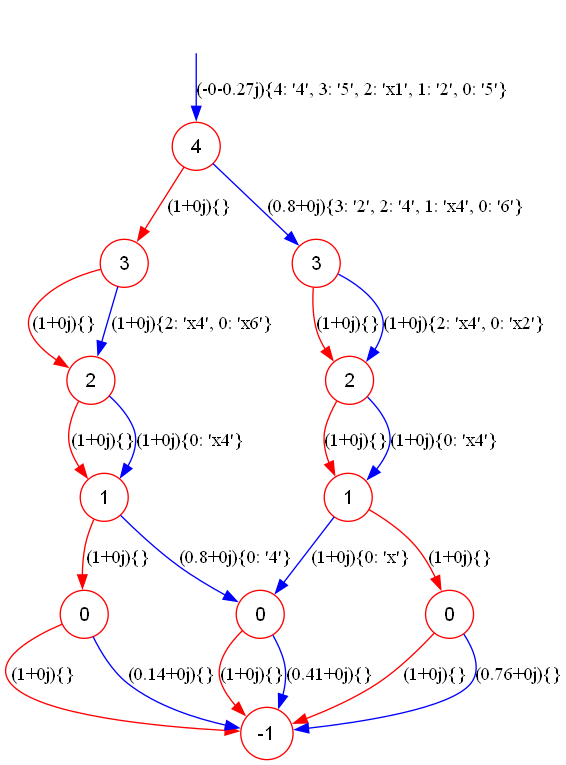

In [14]:
n=5
m=100

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
tdd.show(False)

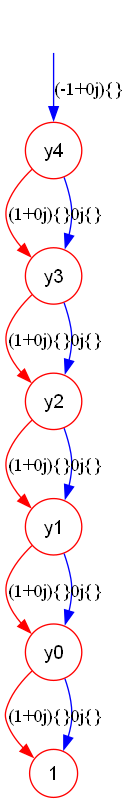

In [10]:
# tdd_new,cir_head,cir_end = eliminate_global_map(tdd)
# tdd_new2,cir_head2,cir_end2 = eliminate_border_control(tdd_new)
# tdd_new3,cir_head3,cir_end3 = eliminate_sigle_qubit_gates(tdd_new2)
# tdd_new4,cir_head4,cir_end4 = merge_multi_control(tdd_new3)
# tdd_new5,cir_head5,cir_end5 = merge_dif_branch_weight(tdd_new4)
# tdd_new5.show()
tdd_new6,cir_head6,cir_end6 = state_pre(tdd)
# print(computed_table_pre)
tdd_new6.show()

In [11]:
cir_end6.draw()

┌────────┐┌───┐┌──────┐     ┌───┐                   
q_0: ─┤ P(π/2) ├┤ X ├┤ P(π) ├─────┤ X ├───────────────────
     ┌┴────────┤└───┘└──────┘     └─┬─┘                   
q_1: ┤ P(3π/2) ├────────────────────┼─────────────────────
     └┬────────┤┌───┐┌──────┐┌───┐  │                     
q_2: ─┤ P(π/2) ├┤ X ├┤ P(π) ├┤ X ├──┼─────────────────────
      └────────┘└───┘└──────┘└─┬─┘  │  ┌─────────┐┌──────┐
q_3: ──────────────────────────■────■──┤ Unitary ├┤ P(π) ├
                                       └─────────┘└──────┘
q_4: ─────────────────────────────────────────────────────

In [12]:
n=5
m=100
g_num = 0
g_num2=0
g_num3=0
r = 20
tt = 0
for k in range(r):
    if k%10==0:
        print(k)
    k+=1
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,True,n)
    if tdd2.node.key!=n-1:
        continue
    # if tdd2.node_number()>n+1:
    #     print('-')
    print('-')
    print(tdd2.node_number())
    t_start = time.time()
    tdd_2,cir_h2,cir_e2 = state_pre(tdd2)
    tt+=time.time()-t_start
    print('-')
    g_num+=len(cir_e2)
    g_num2+=get_gate_data2(cir)
    g_num3+=get_gate_data2(cir_e2)
    print(get_gate_data(cir),get_gate_data(cir_e2))
    if not is_reduced(tdd_2):
        print('find_one')
        break
print(tt/r,g_num/r,g_num2/r,g_num3/r)

0
-
9
-
{1: 89, 2: 11} {1: 16, 2: 15}
-
6
-
{1: 85, 2: 15} {1: 11, 2: 6}
-
8
-
{1: 84, 2: 16} {1: 16, 2: 5, 3: 1}
-
12
-
{1: 85, 2: 15} {1: 19, 2: 14, 3: 4}


C:\Users\23626\AppData\Local\Temp\ipykernel_13136\2093481972.py:54: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir.data:


-
6
-
{1: 90, 2: 10} {1: 15, 2: 6}
-
14
-
{1: 84, 2: 16} {1: 35, 2: 77, 3: 40, 4: 18, 5: 4}
-
6
-
{2: 14, 1: 86} {1: 17, 2: 9}
-
6
-
{1: 84, 2: 16} {1: 16, 2: 2}
-
12
-
{1: 84, 2: 16} {1: 19, 2: 34, 3: 19, 4: 4}
-
10



KeyboardInterrupt



In [ ]:
cir.draw()

In [ ]:
tdd.show()

In [ ]:
tdd_new,cir_head,cir_end = eliminate_global_map(tdd2)
tdd_new2,cir_head2,cir_end2 = eliminate_border_control(tdd_new)
tdd_new3,cir_head3,cir_end3 = eliminate_sigle_qubit_gates(tdd_new2)
tdd_new4,cir_head4,cir_end4 = merge_multi_control(tdd_new3)
tdd_new5,cir_head5,cir_end5 = merge_dif_branch_weight(tdd_new4)
tdd_new6,cir_head6,cir_end6 = merge_non_reduce_branch(tdd_new5)
tdd_new6.show()

In [ ]:
a,b = get_non_reduce_branch(tdd_new6)
print(b)
a.show()